In [1]:
import torch
import torch.nn as nn

import numpy as np
import cv2
import matplotlib.pyplot as plt

import random
import pickle as pkl

In [2]:
from DarkNet import DarkNet
from utils import get_input_img, bbox_nms, bbox_transform

In [3]:
IMG_SIZE = 416
NUM_CLASSES = 20
OBJ_CONF = 0.5
NMS_THRES = 0.4
CUDA = torch.cuda.is_available()

In [4]:
darknet = DarkNet(IMG_SIZE, NUM_CLASSES)

if CUDA:
    darknet.cuda()

darknet.eval()

DarkNet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch

In [32]:
def visualize_yolo(model, img_dir, img_size, obj_classes, obj_conf=0.5, nms_thres=0.4, CUDA=True):
    
    input_img, ori_img = get_input_img(img_dir, img_size)
    
    if CUDA:
        input_img = input_img.cuda()
        
    prediction, _, _, _ = darknet(input_img)
    
    output = bbox_nms(prediction, obj_conf, nms_thres)
    bbox_img = ori_img.copy()
    
    # 如果图中未检测到目标，则直接返回原图
    if len(output) == 0:
        plt.imshow(bbox_img)
        return bbox_img
    
    pt1, pt2 = bbox_transform(output, ori_img, img_size)
    
    obj_colors = pkl.load(open("data/pallete", "rb"))
    obj_colors = random.sample(obj_colors, len(obj_classes))

    for i in range(len(output)):

        cls = int(output[i, -1])
        label = "{}".format(obj_classes[cls])
        color = obj_colors[cls]

        cv2.rectangle(bbox_img, pt1[i], pt2[i], color, 2)

        text_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 1, 1)[0]
        text_pt2 = (pt1[i][0] + text_size[0], pt1[i][1] + text_size[1] + 4)

        cv2.rectangle(bbox_img, pt1[i], text_pt2, color, -1)

        cv2.putText(bbox_img, label, (pt1[i][0], pt1[i][1] + text_size[1] + 4), cv2.FONT_HERSHEY_SIMPLEX, 1, [255, 255, 255], 1)
    
    plt.imshow(bbox_img)
    return bbox_img

In [33]:
obj_classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 
               'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

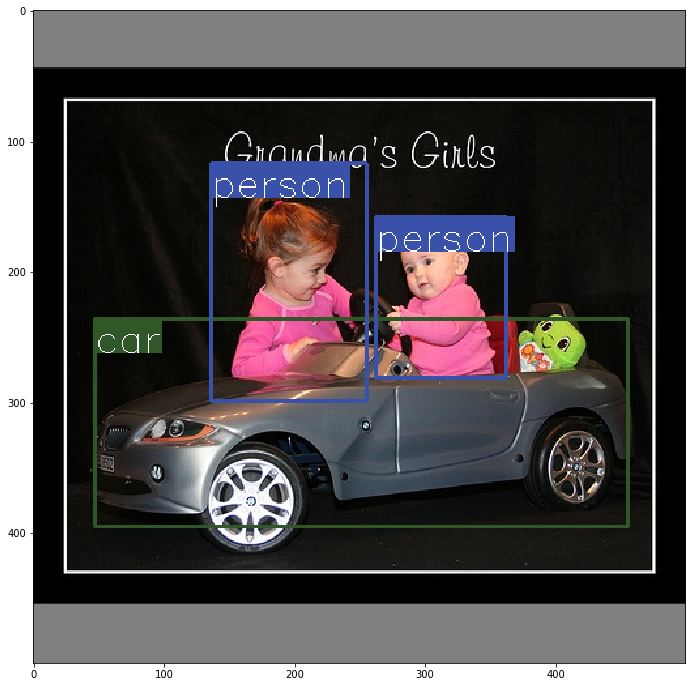

In [42]:
plt.figure(figsize=(12, 12))
vis_img = visualize_yolo(darknet, "imgs/baby.jpg", IMG_SIZE, obj_classes)

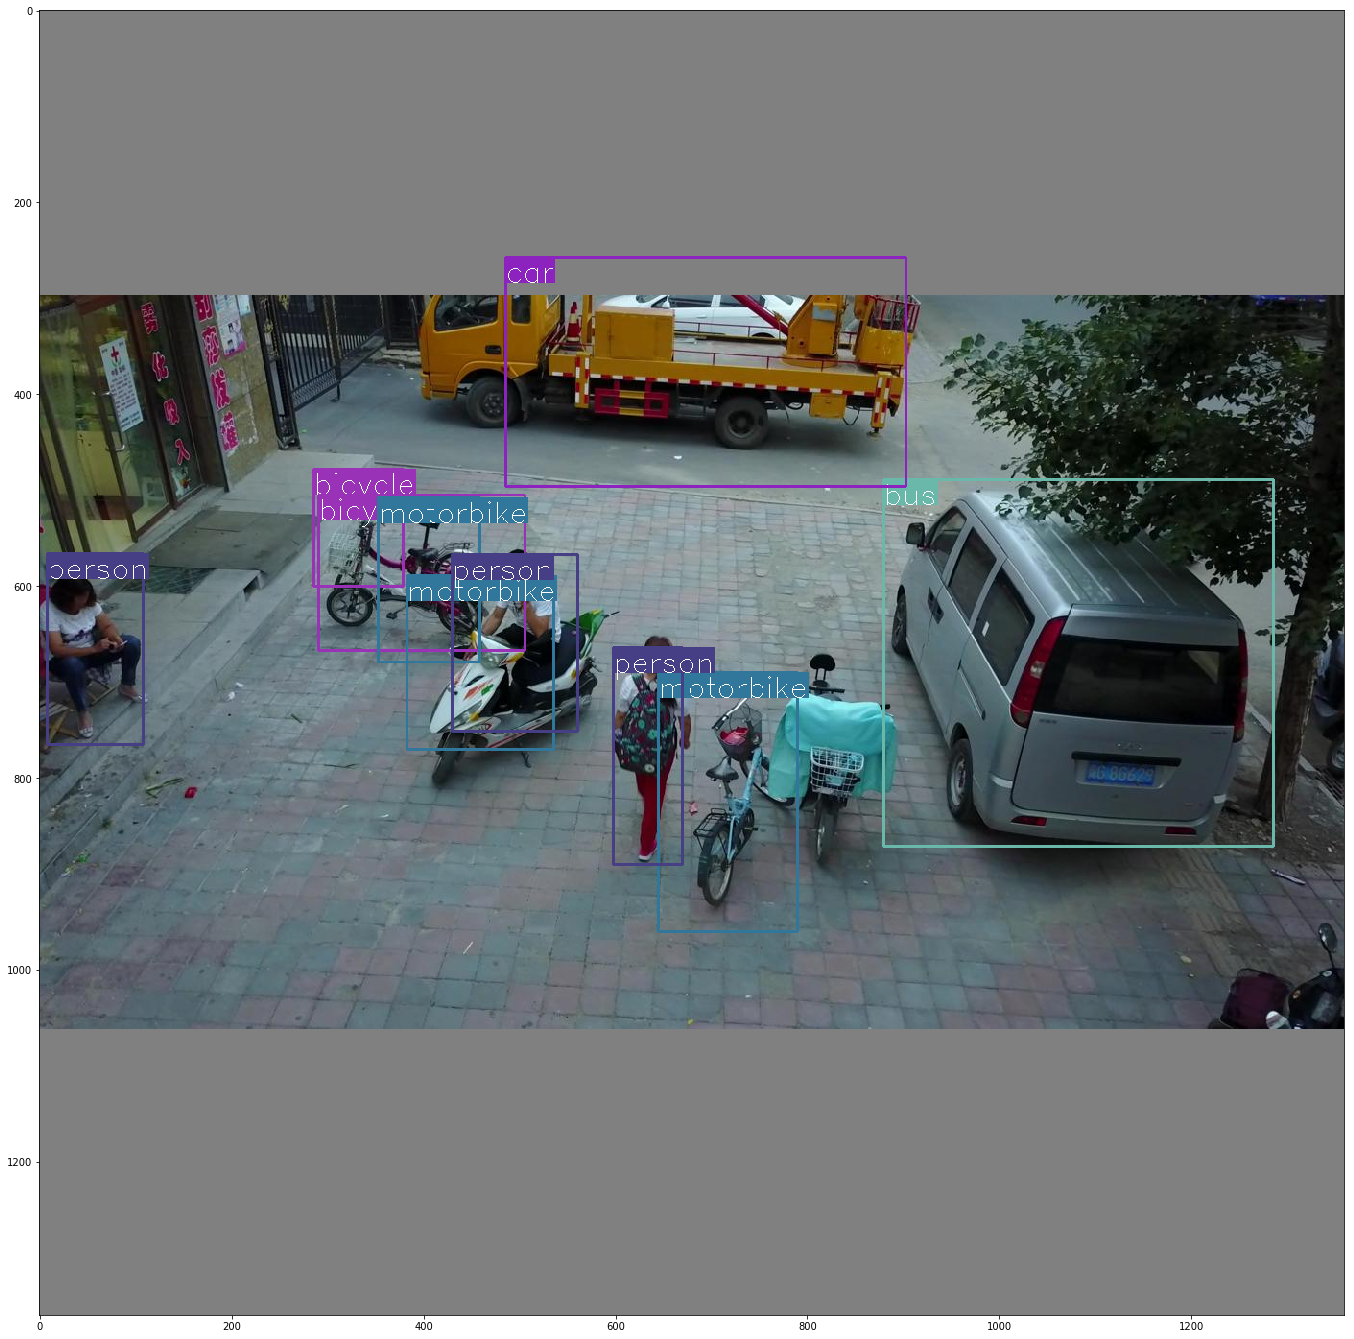

In [44]:
plt.figure(figsize=(24, 24))
vis_img = visualize_yolo(darknet, "data/VisDrone2019-DET-val/images/0000103_02964_d_0000030.jpg", IMG_SIZE, obj_classes)